# Ansteuerung AD

In [5]:
%matplotlib inline
import math as m
import cmath as cm
from ctypes import *
from WaveFormsSDK.dwfconstants import *
import sys
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import numpy as np
from base_signals import Sinus
import copy
from plot_oop import PlotSimple2
import time
dwf = cdll.dwf
dpi = 140

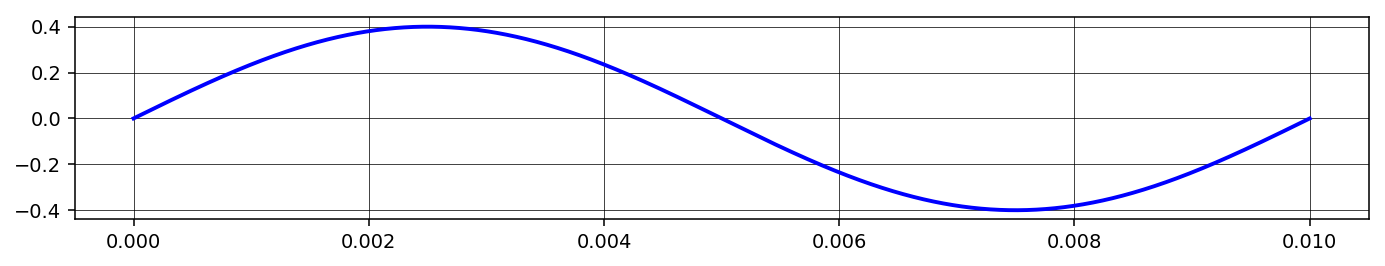

In [6]:
# Signalgenerator
n_sp = 2 ** 12
offset = 0.0
n_1 = 1
f_1 = 100; sin_1 = Sinus(f=f_1, amplitude=2.00, phase=0*np.pi/180.0, n=n_1, n_sp=n_sp)
signal = sin_1.signal
signal += offset
signal *= 0.2 # Skalierung der Ausgabe auf +-5V
t_sp = sin_1.t[-1]  # Betrachtete Zeitspanne
f_sp = 1 / t_sp  # Auflösung des Signales im Frequenzbereich
sampling_rate = f_sp * n_sp  # Abtastfrequenz

plot_fourierreihe = PlotSimple2(width=10, height=2, dpi=dpi)
plot_fourierreihe.plot(sin_1.t, [signal])

In [11]:
hdwf = c_int()
rgdSamples = (c_double*n_sp)()
channel = c_int(0)

# samples to c_double
for i in range(0, n_sp, 1):
    rgdSamples[i] = c_double(signal[i])

    
version = create_string_buffer(16)
dwf.FDwfGetVersion(version)
print("DWF Version: "+str(version.value))

#open device
cdevices = c_int()
dwf.FDwfEnum(c_int(0), byref(cdevices))
print("Number of Devices: " + str(cdevices.value))

# print("Opening first device")
# hdwf = c_int()
dwf.FDwfDeviceOpen(c_int(0), byref(hdwf))

if cdevices.value == 0:
    print("no device available")
    quit()
    
if hdwf.value == hdwfNone.value:
    print("failed to open device")
    quit()

#===========================================================================================
print("Generating custom waveform...")
dwf.FDwfAnalogOutNodeEnableSet(hdwf, channel, AnalogOutNodeCarrier, c_bool(True))
dwf.FDwfAnalogOutNodeFunctionSet(hdwf, channel, AnalogOutNodeCarrier, funcCustom) 
dwf.FDwfAnalogOutNodeDataSet(hdwf, channel, AnalogOutNodeCarrier, rgdSamples, c_int(n_sp))
dwf.FDwfAnalogOutNodeFrequencySet(hdwf, channel, AnalogOutNodeCarrier, c_double(f_sp)) 
dwf.FDwfAnalogOutNodeAmplitudeSet(hdwf, channel, AnalogOutNodeCarrier, c_double(5.0)) 
dwf.FDwfAnalogOutRunSet(hdwf, channel, c_double(t_sp))  # run for 1 periods
dwf.FDwfAnalogOutWaitSet(hdwf, channel, c_double(0.0))  # wait 0.0 s
dwf.FDwfAnalogOutRepeatSet(hdwf, channel, c_int(500)) # repeat x times
# dwf.FDwfAnalogOutConfigure(hdwf, channel, c_bool(True))  # starte Signalgenerator
#===========================================================================================
print('Einlesen der Analogsignale')
dwf.FDwfAnalogInFrequencySet(hdwf, c_double(sampling_rate))
# print("Set range for all channels")
dwf.FDwfAnalogInChannelRangeSet(hdwf, c_int(-1), c_double(10.0))
dwf.FDwfAnalogInBufferSizeSet(hdwf, c_int(n_sp))

# print("Wait after first device opening the analog in offset to stabilize")
#time.sleep(0.5)
print("Starting acquisition")
dwf.FDwfAnalogOutConfigure(hdwf, channel, c_bool(True))  # starte Signalgenerator
dwf.FDwfAnalogInConfigure(hdwf, c_int(1), c_int(1))

print("waiting to finish")
sts = c_int()
while True:
    dwf.FDwfAnalogInStatus(hdwf, c_int(1), byref(sts))
    if sts.value == DwfStateDone.value :
        break
    time.sleep(0.1)
#===========================================================================================
# Daten aus Oszilloskop auslesen
# print("   reading data")
rg1 = (c_double * n_sp)()
dwf.FDwfAnalogInStatusData(hdwf, c_int(0), rg1, len(rg1)) # get channel 1 data
rg2 = (c_double * n_sp)()
dwf.FDwfAnalogInStatusData(hdwf, c_int(1), rg2, len(rg2)) # get channel 2 data

dwf.FDwfDeviceCloseAll()

ch1 = [0.0] * len(rg1) # Initialisieren
ch2 = [0.0] * len(rg2)
for i in range(0, len(ch1)):
    ch1[i] = rg1[i]
    ch2[i] = rg2[i]
#===========================================================================================
# Signalgenerator deaktivieren
dwf.FDwfAnalogOutReset(hdwf, channel)
dwf.FDwfDeviceCloseAll()
#===========================================================================================
print('finished')

DWF Version: b'3.12.1'
Number of Devices: 1
Generating custom waveform...
Einlesen der Analogsignale
Starting acquisition
waiting to finish
finished


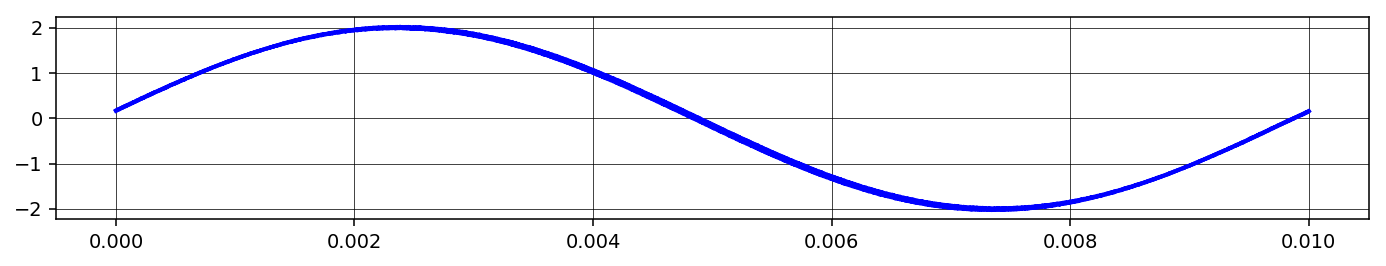

In [12]:
plot_messung = PlotSimple2(width=10, height=2, dpi=dpi)
plot_messung.plot(sin_1.t, [ch1, ch2])